<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[16:10:30] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


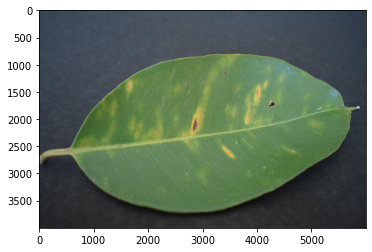

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

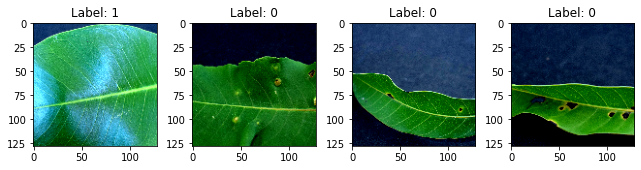

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[16:10:38] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[16:10:40] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2425302320813962 samples/sec                   batch loss = 0.48650503158569336 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2672788684630267 samples/sec                   batch loss = 0.879459798336029 | accuracy = 0.65


Epoch[1] Batch[15] Speed: 1.255314535407914 samples/sec                   batch loss = 1.4340991973876953 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.2605752994137729 samples/sec                   batch loss = 1.104812502861023 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2636328921433129 samples/sec                   batch loss = 0.8732305765151978 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.2631454997341156 samples/sec                   batch loss = 0.42244860529899597 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.2651197470909106 samples/sec                   batch loss = 0.7512573003768921 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.2640484667478615 samples/sec                   batch loss = 0.4276352524757385 | accuracy = 0.5875


Epoch[1] Batch[45] Speed: 1.260681294148544 samples/sec                   batch loss = 0.2615221440792084 | accuracy = 0.6222222222222222


Epoch[1] Batch[50] Speed: 1.2639818993070602 samples/sec                   batch loss = 0.27731040120124817 | accuracy = 0.63


Epoch[1] Batch[55] Speed: 1.2636269913336053 samples/sec                   batch loss = 0.8685845136642456 | accuracy = 0.6454545454545455


Epoch[1] Batch[60] Speed: 1.2699954142378453 samples/sec                   batch loss = 0.7658852338790894 | accuracy = 0.65


Epoch[1] Batch[65] Speed: 1.2704596305802065 samples/sec                   batch loss = 0.23144756257534027 | accuracy = 0.65


Epoch[1] Batch[70] Speed: 1.268979689022669 samples/sec                   batch loss = 0.4505743384361267 | accuracy = 0.6357142857142857


Epoch[1] Batch[75] Speed: 1.2691028457810647 samples/sec                   batch loss = 0.8180438876152039 | accuracy = 0.6333333333333333


Epoch[1] Batch[80] Speed: 1.2739683036028533 samples/sec                   batch loss = 0.2807919383049011 | accuracy = 0.646875


Epoch[1] Batch[85] Speed: 1.2644905228495855 samples/sec                   batch loss = 0.49171146750450134 | accuracy = 0.6470588235294118


Epoch[1] Batch[90] Speed: 1.272234026168843 samples/sec                   batch loss = 0.5717194080352783 | accuracy = 0.6472222222222223


Epoch[1] Batch[95] Speed: 1.2655512880742958 samples/sec                   batch loss = 0.5370302200317383 | accuracy = 0.6526315789473685


Epoch[1] Batch[100] Speed: 1.2676212728545917 samples/sec                   batch loss = 0.4752400517463684 | accuracy = 0.655


Epoch[1] Batch[105] Speed: 1.2639029607432741 samples/sec                   batch loss = 0.5369249582290649 | accuracy = 0.6571428571428571


Epoch[1] Batch[110] Speed: 1.2660343292594674 samples/sec                   batch loss = 0.4487226903438568 | accuracy = 0.6568181818181819


Epoch[1] Batch[115] Speed: 1.2659704183111733 samples/sec                   batch loss = 1.2403082847595215 | accuracy = 0.6521739130434783


Epoch[1] Batch[120] Speed: 1.2593606175524101 samples/sec                   batch loss = 0.651689887046814 | accuracy = 0.65625


Epoch[1] Batch[125] Speed: 1.2677163860944252 samples/sec                   batch loss = 0.7908249497413635 | accuracy = 0.648


Epoch[1] Batch[130] Speed: 1.2688578036888898 samples/sec                   batch loss = 0.5762447118759155 | accuracy = 0.6480769230769231


Epoch[1] Batch[135] Speed: 1.2666369760373368 samples/sec                   batch loss = 0.3550737202167511 | accuracy = 0.65


Epoch[1] Batch[140] Speed: 1.2674841356877296 samples/sec                   batch loss = 0.638671338558197 | accuracy = 0.6410714285714286


Epoch[1] Batch[145] Speed: 1.257649547201018 samples/sec                   batch loss = 0.8976162075996399 | accuracy = 0.6396551724137931


Epoch[1] Batch[150] Speed: 1.2694740924913128 samples/sec                   batch loss = 0.7036052942276001 | accuracy = 0.6416666666666667


Epoch[1] Batch[155] Speed: 1.2687269229960656 samples/sec                   batch loss = 0.5719417929649353 | accuracy = 0.6419354838709678


Epoch[1] Batch[160] Speed: 1.2702137758085272 samples/sec                   batch loss = 0.593171238899231 | accuracy = 0.65


Epoch[1] Batch[165] Speed: 1.2623130556265316 samples/sec                   batch loss = 0.5426672697067261 | accuracy = 0.6515151515151515


Epoch[1] Batch[170] Speed: 1.2696364491229843 samples/sec                   batch loss = 0.5713650584220886 | accuracy = 0.6588235294117647


Epoch[1] Batch[175] Speed: 1.272094635282721 samples/sec                   batch loss = 0.5586371421813965 | accuracy = 0.6642857142857143


Epoch[1] Batch[180] Speed: 1.2681400192384122 samples/sec                   batch loss = 0.576198399066925 | accuracy = 0.6666666666666666


Epoch[1] Batch[185] Speed: 1.2698939031193255 samples/sec                   batch loss = 0.30170416831970215 | accuracy = 0.672972972972973


Epoch[1] Batch[190] Speed: 1.2699015927874575 samples/sec                   batch loss = 0.30672189593315125 | accuracy = 0.6789473684210526


Epoch[1] Batch[195] Speed: 1.2674925622556952 samples/sec                   batch loss = 1.1762359142303467 | accuracy = 0.6807692307692308


Epoch[1] Batch[200] Speed: 1.2653242199788026 samples/sec                   batch loss = 0.36201927065849304 | accuracy = 0.68125


Epoch[1] Batch[205] Speed: 1.2684486513994604 samples/sec                   batch loss = 0.2638249695301056 | accuracy = 0.6780487804878049


Epoch[1] Batch[210] Speed: 1.2716594885822334 samples/sec                   batch loss = 1.2069337368011475 | accuracy = 0.6761904761904762


Epoch[1] Batch[215] Speed: 1.2622604410699665 samples/sec                   batch loss = 0.49434611201286316 | accuracy = 0.6755813953488372


Epoch[1] Batch[220] Speed: 1.267626827918228 samples/sec                   batch loss = 0.40707138180732727 | accuracy = 0.6772727272727272


Epoch[1] Batch[225] Speed: 1.2692346682329716 samples/sec                   batch loss = 1.1381946802139282 | accuracy = 0.6744444444444444


Epoch[1] Batch[230] Speed: 1.2648384782779962 samples/sec                   batch loss = 0.5465806126594543 | accuracy = 0.6760869565217391


Epoch[1] Batch[235] Speed: 1.2706620801130122 samples/sec                   batch loss = 0.6247628927230835 | accuracy = 0.6734042553191489


Epoch[1] Batch[240] Speed: 1.262445086189343 samples/sec                   batch loss = 0.6762665510177612 | accuracy = 0.671875


Epoch[1] Batch[245] Speed: 1.269770112280533 samples/sec                   batch loss = 0.541999876499176 | accuracy = 0.6683673469387755


Epoch[1] Batch[250] Speed: 1.2681474959681638 samples/sec                   batch loss = 0.3060024082660675 | accuracy = 0.67


Epoch[1] Batch[255] Speed: 1.265283472791514 samples/sec                   batch loss = 0.4566196799278259 | accuracy = 0.6715686274509803


Epoch[1] Batch[260] Speed: 1.2636105264624595 samples/sec                   batch loss = 0.5796427726745605 | accuracy = 0.6701923076923076


Epoch[1] Batch[265] Speed: 1.261245857608326 samples/sec                   batch loss = 0.5269765853881836 | accuracy = 0.6735849056603773


Epoch[1] Batch[270] Speed: 1.2661093301555104 samples/sec                   batch loss = 0.4874982237815857 | accuracy = 0.6759259259259259


Epoch[1] Batch[275] Speed: 1.264665906585382 samples/sec                   batch loss = 0.40168026089668274 | accuracy = 0.6772727272727272


Epoch[1] Batch[280] Speed: 1.2704082586907732 samples/sec                   batch loss = 1.0380810499191284 | accuracy = 0.6785714285714286


Epoch[1] Batch[285] Speed: 1.2659242803369335 samples/sec                   batch loss = 0.5898967981338501 | accuracy = 0.6780701754385965


Epoch[1] Batch[290] Speed: 1.2737792087774458 samples/sec                   batch loss = 0.3818250000476837 | accuracy = 0.6793103448275862


Epoch[1] Batch[295] Speed: 1.2678654542813694 samples/sec                   batch loss = 0.7339457273483276 | accuracy = 0.6805084745762712


Epoch[1] Batch[300] Speed: 1.2726795100174906 samples/sec                   batch loss = 0.40482547879219055 | accuracy = 0.6825


Epoch[1] Batch[305] Speed: 1.2738914982181921 samples/sec                   batch loss = 1.5296275615692139 | accuracy = 0.6795081967213115


Epoch[1] Batch[310] Speed: 1.265515108254572 samples/sec                   batch loss = 0.3848273456096649 | accuracy = 0.6806451612903226


Epoch[1] Batch[315] Speed: 1.2663995765688978 samples/sec                   batch loss = 0.23095619678497314 | accuracy = 0.6841269841269841


Epoch[1] Batch[320] Speed: 1.2719153531026428 samples/sec                   batch loss = 0.6375550627708435 | accuracy = 0.6859375


Epoch[1] Batch[325] Speed: 1.2692304433451027 samples/sec                   batch loss = 0.4507621228694916 | accuracy = 0.686923076923077


Epoch[1] Batch[330] Speed: 1.261876601534856 samples/sec                   batch loss = 0.5142720341682434 | accuracy = 0.6840909090909091


Epoch[1] Batch[335] Speed: 1.2626169572610002 samples/sec                   batch loss = 0.4836543798446655 | accuracy = 0.682089552238806


Epoch[1] Batch[340] Speed: 1.264678395000028 samples/sec                   batch loss = 0.2201717644929886 | accuracy = 0.6816176470588236


Epoch[1] Batch[345] Speed: 1.2657487384170054 samples/sec                   batch loss = 0.595136821269989 | accuracy = 0.6840579710144927


Epoch[1] Batch[350] Speed: 1.2629098824493468 samples/sec                   batch loss = 0.43092548847198486 | accuracy = 0.6857142857142857


Epoch[1] Batch[355] Speed: 1.2658429978023642 samples/sec                   batch loss = 0.570949137210846 | accuracy = 0.6852112676056338


Epoch[1] Batch[360] Speed: 1.2640982778738106 samples/sec                   batch loss = 0.408536434173584 | accuracy = 0.6854166666666667


Epoch[1] Batch[365] Speed: 1.2598846390972982 samples/sec                   batch loss = 0.9874963760375977 | accuracy = 0.6835616438356165


Epoch[1] Batch[370] Speed: 1.2694432590305837 samples/sec                   batch loss = 0.31812623143196106 | accuracy = 0.6851351351351351


Epoch[1] Batch[375] Speed: 1.2662870747620545 samples/sec                   batch loss = 0.35234448313713074 | accuracy = 0.6853333333333333


Epoch[1] Batch[380] Speed: 1.257438782249513 samples/sec                   batch loss = 0.7345443367958069 | accuracy = 0.6848684210526316


Epoch[1] Batch[385] Speed: 1.2696606620721742 samples/sec                   batch loss = 0.23619616031646729 | accuracy = 0.687012987012987


Epoch[1] Batch[390] Speed: 1.2690311374190915 samples/sec                   batch loss = 0.375413715839386 | accuracy = 0.6878205128205128


Epoch[1] Batch[395] Speed: 1.2622334706873242 samples/sec                   batch loss = 0.5242787599563599 | accuracy = 0.6860759493670886


Epoch[1] Batch[400] Speed: 1.2573605645781274 samples/sec                   batch loss = 0.48432132601737976 | accuracy = 0.685625


Epoch[1] Batch[405] Speed: 1.2636127154090377 samples/sec                   batch loss = 0.46287745237350464 | accuracy = 0.6839506172839506


Epoch[1] Batch[410] Speed: 1.2625824652830038 samples/sec                   batch loss = 0.3879387080669403 | accuracy = 0.6847560975609757


Epoch[1] Batch[415] Speed: 1.2622618655940525 samples/sec                   batch loss = 0.874660313129425 | accuracy = 0.6867469879518072


Epoch[1] Batch[420] Speed: 1.2607001458386686 samples/sec                   batch loss = 0.5957794189453125 | accuracy = 0.6875


Epoch[1] Batch[425] Speed: 1.2602400983000162 samples/sec                   batch loss = 0.6676208972930908 | accuracy = 0.6858823529411765


Epoch[1] Batch[430] Speed: 1.2647583839012813 samples/sec                   batch loss = 0.41212302446365356 | accuracy = 0.686046511627907


Epoch[1] Batch[435] Speed: 1.2548045373722307 samples/sec                   batch loss = 0.175837904214859 | accuracy = 0.6867816091954023


Epoch[1] Batch[440] Speed: 1.2560330096527705 samples/sec                   batch loss = 0.5255639553070068 | accuracy = 0.6869318181818181


Epoch[1] Batch[445] Speed: 1.2644913805864295 samples/sec                   batch loss = 0.8174633979797363 | accuracy = 0.6882022471910112


Epoch[1] Batch[450] Speed: 1.2634596026099063 samples/sec                   batch loss = 0.17746475338935852 | accuracy = 0.6877777777777778


Epoch[1] Batch[455] Speed: 1.2662845898160995 samples/sec                   batch loss = 1.0010690689086914 | accuracy = 0.6879120879120879


Epoch[1] Batch[460] Speed: 1.2710980852025542 samples/sec                   batch loss = 0.8171927332878113 | accuracy = 0.6891304347826087


Epoch[1] Batch[465] Speed: 1.2657060541342835 samples/sec                   batch loss = 1.8693876266479492 | accuracy = 0.689247311827957


Epoch[1] Batch[470] Speed: 1.2605026573746645 samples/sec                   batch loss = 0.4900602698326111 | accuracy = 0.6867021276595745


Epoch[1] Batch[475] Speed: 1.2632481224701668 samples/sec                   batch loss = 0.6418879628181458 | accuracy = 0.6863157894736842


Epoch[1] Batch[480] Speed: 1.2670608448725742 samples/sec                   batch loss = 0.5386708974838257 | accuracy = 0.6875


Epoch[1] Batch[485] Speed: 1.2685354482930074 samples/sec                   batch loss = 0.5862252712249756 | accuracy = 0.6881443298969072


Epoch[1] Batch[490] Speed: 1.266787607825063 samples/sec                   batch loss = 0.35616642236709595 | accuracy = 0.689795918367347


Epoch[1] Batch[495] Speed: 1.2704868574419568 samples/sec                   batch loss = 0.6897512674331665 | accuracy = 0.6888888888888889


Epoch[1] Batch[500] Speed: 1.260747893344972 samples/sec                   batch loss = 0.49973171949386597 | accuracy = 0.6905


Epoch[1] Batch[505] Speed: 1.2674591439121383 samples/sec                   batch loss = 0.8372031450271606 | accuracy = 0.6915841584158415


Epoch[1] Batch[510] Speed: 1.2659921033655623 samples/sec                   batch loss = 0.8500287532806396 | accuracy = 0.6911764705882353


Epoch[1] Batch[515] Speed: 1.2607030825848702 samples/sec                   batch loss = 0.22250962257385254 | accuracy = 0.6927184466019417


Epoch[1] Batch[520] Speed: 1.2579994070375375 samples/sec                   batch loss = 0.5362831354141235 | accuracy = 0.6913461538461538


Epoch[1] Batch[525] Speed: 1.2575583892876023 samples/sec                   batch loss = 0.6781419515609741 | accuracy = 0.6928571428571428


Epoch[1] Batch[530] Speed: 1.258355973873755 samples/sec                   batch loss = 0.388338178396225 | accuracy = 0.6938679245283019


Epoch[1] Batch[535] Speed: 1.2566017931342655 samples/sec                   batch loss = 1.178049921989441 | accuracy = 0.694392523364486


Epoch[1] Batch[540] Speed: 1.2603235031569282 samples/sec                   batch loss = 0.7261449694633484 | accuracy = 0.6935185185185185


Epoch[1] Batch[545] Speed: 1.2585172926316213 samples/sec                   batch loss = 0.47046592831611633 | accuracy = 0.6931192660550459


Epoch[1] Batch[550] Speed: 1.2579169697015138 samples/sec                   batch loss = 0.7642173171043396 | accuracy = 0.6909090909090909


Epoch[1] Batch[555] Speed: 1.2593192137571703 samples/sec                   batch loss = 0.5199907422065735 | accuracy = 0.6918918918918919


Epoch[1] Batch[560] Speed: 1.252248880010396 samples/sec                   batch loss = 0.9936900734901428 | accuracy = 0.6901785714285714


Epoch[1] Batch[565] Speed: 1.262520992518209 samples/sec                   batch loss = 1.0154445171356201 | accuracy = 0.6902654867256637


Epoch[1] Batch[570] Speed: 1.2565844755506952 samples/sec                   batch loss = 0.5322570204734802 | accuracy = 0.6916666666666667


Epoch[1] Batch[575] Speed: 1.2648293241215158 samples/sec                   batch loss = 0.40716850757598877 | accuracy = 0.6921739130434783


Epoch[1] Batch[580] Speed: 1.256949563459702 samples/sec                   batch loss = 0.6170091032981873 | accuracy = 0.6913793103448276


Epoch[1] Batch[585] Speed: 1.2586685488309395 samples/sec                   batch loss = 0.5285884141921997 | accuracy = 0.6927350427350427


Epoch[1] Batch[590] Speed: 1.2614489852447632 samples/sec                   batch loss = 0.4889867305755615 | accuracy = 0.6932203389830508


Epoch[1] Batch[595] Speed: 1.2536245512672937 samples/sec                   batch loss = 0.7713251113891602 | accuracy = 0.6932773109243697


Epoch[1] Batch[600] Speed: 1.2584921812013379 samples/sec                   batch loss = 0.8667445778846741 | accuracy = 0.6933333333333334


Epoch[1] Batch[605] Speed: 1.262007211785282 samples/sec                   batch loss = 0.7148171067237854 | accuracy = 0.6925619834710743


Epoch[1] Batch[610] Speed: 1.2599283508991583 samples/sec                   batch loss = 0.4399786591529846 | accuracy = 0.6934426229508197


Epoch[1] Batch[615] Speed: 1.2562065252713122 samples/sec                   batch loss = 0.684464156627655 | accuracy = 0.6934959349593496


Epoch[1] Batch[620] Speed: 1.262897428937435 samples/sec                   batch loss = 0.7299107909202576 | accuracy = 0.692741935483871


Epoch[1] Batch[625] Speed: 1.263616141601516 samples/sec                   batch loss = 0.35870859026908875 | accuracy = 0.6932


Epoch[1] Batch[630] Speed: 1.2605581562742898 samples/sec                   batch loss = 0.4509410262107849 | accuracy = 0.6932539682539682


Epoch[1] Batch[635] Speed: 1.2626299753844135 samples/sec                   batch loss = 0.37251046299934387 | accuracy = 0.6937007874015748


Epoch[1] Batch[640] Speed: 1.2576428536678628 samples/sec                   batch loss = 0.5103166103363037 | accuracy = 0.693359375


Epoch[1] Batch[645] Speed: 1.2635729348677471 samples/sec                   batch loss = 0.3867701590061188 | accuracy = 0.6934108527131783


Epoch[1] Batch[650] Speed: 1.2579246093207288 samples/sec                   batch loss = 0.3576662838459015 | accuracy = 0.6938461538461539


Epoch[1] Batch[655] Speed: 1.2592793250043477 samples/sec                   batch loss = 0.5946037173271179 | accuracy = 0.6938931297709924


Epoch[1] Batch[660] Speed: 1.2561598735425603 samples/sec                   batch loss = 0.5027446746826172 | accuracy = 0.6946969696969697


Epoch[1] Batch[665] Speed: 1.256769534866422 samples/sec                   batch loss = 0.2985774874687195 | accuracy = 0.6951127819548872


Epoch[1] Batch[670] Speed: 1.2564770983653801 samples/sec                   batch loss = 0.3842673599720001 | accuracy = 0.6955223880597015


Epoch[1] Batch[675] Speed: 1.2602851601661569 samples/sec                   batch loss = 0.4754188358783722 | accuracy = 0.6944444444444444


Epoch[1] Batch[680] Speed: 1.2597098222162888 samples/sec                   batch loss = 0.3087978661060333 | accuracy = 0.6952205882352941


Epoch[1] Batch[685] Speed: 1.261478008819781 samples/sec                   batch loss = 1.109590768814087 | accuracy = 0.6937956204379562


Epoch[1] Batch[690] Speed: 1.2650458172628387 samples/sec                   batch loss = 0.4567570984363556 | accuracy = 0.6945652173913044


Epoch[1] Batch[695] Speed: 1.2643818855906257 samples/sec                   batch loss = 0.7458391189575195 | accuracy = 0.6946043165467626


Epoch[1] Batch[700] Speed: 1.2675249289788717 samples/sec                   batch loss = 0.4954953193664551 | accuracy = 0.6942857142857143


Epoch[1] Batch[705] Speed: 1.26845172025832 samples/sec                   batch loss = 0.4395737648010254 | accuracy = 0.6957446808510638


Epoch[1] Batch[710] Speed: 1.2750838955184916 samples/sec                   batch loss = 0.814452052116394 | accuracy = 0.6950704225352112


Epoch[1] Batch[715] Speed: 1.2688715266157446 samples/sec                   batch loss = 0.5821732878684998 | accuracy = 0.6954545454545454


Epoch[1] Batch[720] Speed: 1.2671847779660574 samples/sec                   batch loss = 0.4486081600189209 | accuracy = 0.6954861111111111


Epoch[1] Batch[725] Speed: 1.2612459524238924 samples/sec                   batch loss = 0.5590255260467529 | accuracy = 0.6958620689655173


Epoch[1] Batch[730] Speed: 1.2632277677937613 samples/sec                   batch loss = 0.6948708891868591 | accuracy = 0.6955479452054795


Epoch[1] Batch[735] Speed: 1.2574535787348653 samples/sec                   batch loss = 0.5766994953155518 | accuracy = 0.6959183673469388


Epoch[1] Batch[740] Speed: 1.257120694920959 samples/sec                   batch loss = 0.7808935642242432 | accuracy = 0.6959459459459459


Epoch[1] Batch[745] Speed: 1.2607782110992143 samples/sec                   batch loss = 0.6175914406776428 | accuracy = 0.6959731543624161


Epoch[1] Batch[750] Speed: 1.256129871539782 samples/sec                   batch loss = 0.27110135555267334 | accuracy = 0.6956666666666667


Epoch[1] Batch[755] Speed: 1.2542593207006418 samples/sec                   batch loss = 0.5845353603363037 | accuracy = 0.6960264900662252


Epoch[1] Batch[760] Speed: 1.2567172872694237 samples/sec                   batch loss = 0.23980741202831268 | accuracy = 0.6970394736842105


Epoch[1] Batch[765] Speed: 1.26245629581114 samples/sec                   batch loss = 0.3339153826236725 | accuracy = 0.6983660130718954


Epoch[1] Batch[770] Speed: 1.2592208197701953 samples/sec                   batch loss = 0.48200446367263794 | accuracy = 0.698051948051948


Epoch[1] Batch[775] Speed: 1.2592532379924952 samples/sec                   batch loss = 0.4367764890193939 | accuracy = 0.6980645161290323


Epoch[1] Batch[780] Speed: 1.2633576114452385 samples/sec                   batch loss = 0.4391228258609772 | accuracy = 0.6983974358974359


Epoch[1] Batch[785] Speed: 1.2572902712150857 samples/sec                   batch loss = 0.5168540477752686 | accuracy = 0.6990445859872612


[Epoch 1] training: accuracy=0.699238578680203
[Epoch 1] time cost: 650.9620697498322
[Epoch 1] validation: validation accuracy=0.7644444444444445


Epoch[2] Batch[5] Speed: 1.269583702681052 samples/sec                   batch loss = 0.5140050649642944 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2674276422734747 samples/sec                   batch loss = 0.5541317462921143 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2737893633390116 samples/sec                   batch loss = 0.423810213804245 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.266844809469054 samples/sec                   batch loss = 0.5886744260787964 | accuracy = 0.7125


Epoch[2] Batch[25] Speed: 1.27659210527317 samples/sec                   batch loss = 0.38654452562332153 | accuracy = 0.72


Epoch[2] Batch[30] Speed: 1.2722872825159552 samples/sec                   batch loss = 0.5410006642341614 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2670668734891137 samples/sec                   batch loss = 0.6970968842506409 | accuracy = 0.7214285714285714


Epoch[2] Batch[40] Speed: 1.2632581098176336 samples/sec                   batch loss = 0.13170944154262543 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.276318237871253 samples/sec                   batch loss = 1.2779935598373413 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.2666376454326964 samples/sec                   batch loss = 0.2466222047805786 | accuracy = 0.74


Epoch[2] Batch[55] Speed: 1.2693966754901096 samples/sec                   batch loss = 0.2169477641582489 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.277466547741547 samples/sec                   batch loss = 1.0412178039550781 | accuracy = 0.725


Epoch[2] Batch[65] Speed: 1.2672443127506914 samples/sec                   batch loss = 0.24492041766643524 | accuracy = 0.7346153846153847


Epoch[2] Batch[70] Speed: 1.2691921325776931 samples/sec                   batch loss = 0.46815288066864014 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.2689309320792985 samples/sec                   batch loss = 0.1249343529343605 | accuracy = 0.74


Epoch[2] Batch[80] Speed: 1.2704247087874518 samples/sec                   batch loss = 0.23059451580047607 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.2747296999230553 samples/sec                   batch loss = 0.22377356886863708 | accuracy = 0.7529411764705882


Epoch[2] Batch[90] Speed: 1.2696656585099688 samples/sec                   batch loss = 0.33745163679122925 | accuracy = 0.7583333333333333


Epoch[2] Batch[95] Speed: 1.2655183538531434 samples/sec                   batch loss = 0.5731465816497803 | accuracy = 0.7578947368421053


Epoch[2] Batch[100] Speed: 1.2724624231371147 samples/sec                   batch loss = 0.68401700258255 | accuracy = 0.7525


Epoch[2] Batch[105] Speed: 1.271929624388711 samples/sec                   batch loss = 0.6186007261276245 | accuracy = 0.7523809523809524


Epoch[2] Batch[110] Speed: 1.2706212771075194 samples/sec                   batch loss = 0.317966103553772 | accuracy = 0.7545454545454545


Epoch[2] Batch[115] Speed: 1.2713136470811464 samples/sec                   batch loss = 0.1602252870798111 | accuracy = 0.7543478260869565


Epoch[2] Batch[120] Speed: 1.2677888081616226 samples/sec                   batch loss = 0.29859280586242676 | accuracy = 0.7520833333333333


Epoch[2] Batch[125] Speed: 1.2769114742684378 samples/sec                   batch loss = 0.39311712980270386 | accuracy = 0.76


Epoch[2] Batch[130] Speed: 1.2637751944845665 samples/sec                   batch loss = 0.3233444392681122 | accuracy = 0.7615384615384615


Epoch[2] Batch[135] Speed: 1.2729524939972379 samples/sec                   batch loss = 0.45616236329078674 | accuracy = 0.7574074074074074


Epoch[2] Batch[140] Speed: 1.2648152117232092 samples/sec                   batch loss = 1.3071646690368652 | accuracy = 0.7517857142857143


Epoch[2] Batch[145] Speed: 1.262834404624939 samples/sec                   batch loss = 0.7105948328971863 | accuracy = 0.75


Epoch[2] Batch[150] Speed: 1.2677370772693066 samples/sec                   batch loss = 0.463906854391098 | accuracy = 0.7533333333333333


Epoch[2] Batch[155] Speed: 1.2645147305364128 samples/sec                   batch loss = 0.49478286504745483 | accuracy = 0.75


Epoch[2] Batch[160] Speed: 1.2687195353749798 samples/sec                   batch loss = 0.434081494808197 | accuracy = 0.753125


Epoch[2] Batch[165] Speed: 1.2665196515239863 samples/sec                   batch loss = 0.8836668729782104 | accuracy = 0.75


Epoch[2] Batch[170] Speed: 1.2661826198692039 samples/sec                   batch loss = 0.7440674304962158 | accuracy = 0.7514705882352941


Epoch[2] Batch[175] Speed: 1.2734076631938158 samples/sec                   batch loss = 0.19428400695323944 | accuracy = 0.7542857142857143


Epoch[2] Batch[180] Speed: 1.266792007768128 samples/sec                   batch loss = 0.5223979949951172 | accuracy = 0.7527777777777778


Epoch[2] Batch[185] Speed: 1.2674781988548496 samples/sec                   batch loss = 0.19185690581798553 | accuracy = 0.7581081081081081


Epoch[2] Batch[190] Speed: 1.263303768274353 samples/sec                   batch loss = 0.40841183066368103 | accuracy = 0.7605263157894737


Epoch[2] Batch[195] Speed: 1.2694985874295455 samples/sec                   batch loss = 0.6146600842475891 | accuracy = 0.7615384615384615


Epoch[2] Batch[200] Speed: 1.272506336472071 samples/sec                   batch loss = 0.623440146446228 | accuracy = 0.7575


Epoch[2] Batch[205] Speed: 1.2709105153253457 samples/sec                   batch loss = 0.1330784410238266 | accuracy = 0.7585365853658537


Epoch[2] Batch[210] Speed: 1.2647466566475274 samples/sec                   batch loss = 0.4347592890262604 | accuracy = 0.7595238095238095


Epoch[2] Batch[215] Speed: 1.264640358536039 samples/sec                   batch loss = 0.9421338438987732 | accuracy = 0.7593023255813953


Epoch[2] Batch[220] Speed: 1.264659805464855 samples/sec                   batch loss = 0.8267854452133179 | accuracy = 0.7579545454545454


Epoch[2] Batch[225] Speed: 1.2679872448640261 samples/sec                   batch loss = 0.5265228152275085 | accuracy = 0.76


Epoch[2] Batch[230] Speed: 1.2673549742532413 samples/sec                   batch loss = 0.17008374631404877 | accuracy = 0.7608695652173914


Epoch[2] Batch[235] Speed: 1.2668651852153896 samples/sec                   batch loss = 0.7263408899307251 | accuracy = 0.7595744680851064


Epoch[2] Batch[240] Speed: 1.2659349786981282 samples/sec                   batch loss = 0.2710515260696411 | accuracy = 0.7604166666666666


Epoch[2] Batch[245] Speed: 1.270062328166799 samples/sec                   batch loss = 1.2145391702651978 | accuracy = 0.7591836734693878


Epoch[2] Batch[250] Speed: 1.2723136229007133 samples/sec                   batch loss = 0.584540069103241 | accuracy = 0.761


Epoch[2] Batch[255] Speed: 1.271198536803175 samples/sec                   batch loss = 0.5759201049804688 | accuracy = 0.7607843137254902


Epoch[2] Batch[260] Speed: 1.2611308568220347 samples/sec                   batch loss = 0.42677533626556396 | accuracy = 0.7615384615384615


Epoch[2] Batch[265] Speed: 1.2672325393511539 samples/sec                   batch loss = 0.20124489068984985 | accuracy = 0.7650943396226415


Epoch[2] Batch[270] Speed: 1.2729243887185009 samples/sec                   batch loss = 0.768062949180603 | accuracy = 0.7611111111111111


Epoch[2] Batch[275] Speed: 1.2725798860328628 samples/sec                   batch loss = 0.7214198112487793 | accuracy = 0.759090909090909


Epoch[2] Batch[280] Speed: 1.268102828610668 samples/sec                   batch loss = 0.7231605648994446 | accuracy = 0.7580357142857143


Epoch[2] Batch[285] Speed: 1.273738495446996 samples/sec                   batch loss = 0.22655078768730164 | accuracy = 0.7570175438596491


Epoch[2] Batch[290] Speed: 1.2690999657709756 samples/sec                   batch loss = 0.3473269045352936 | accuracy = 0.7551724137931034


Epoch[2] Batch[295] Speed: 1.265163632107791 samples/sec                   batch loss = 0.6146354079246521 | accuracy = 0.7550847457627119


Epoch[2] Batch[300] Speed: 1.2669915677461343 samples/sec                   batch loss = 0.6885181069374084 | accuracy = 0.755


Epoch[2] Batch[305] Speed: 1.267715045023064 samples/sec                   batch loss = 0.2165713906288147 | accuracy = 0.7565573770491804


Epoch[2] Batch[310] Speed: 1.2655805007310355 samples/sec                   batch loss = 0.3680965006351471 | accuracy = 0.7564516129032258


Epoch[2] Batch[315] Speed: 1.270544586097239 samples/sec                   batch loss = 0.36505764722824097 | accuracy = 0.7595238095238095


Epoch[2] Batch[320] Speed: 1.26839418162563 samples/sec                   batch loss = 0.5968981981277466 | accuracy = 0.7578125


Epoch[2] Batch[325] Speed: 1.2654820804628661 samples/sec                   batch loss = 0.35294488072395325 | accuracy = 0.7584615384615384


Epoch[2] Batch[330] Speed: 1.2686881629296163 samples/sec                   batch loss = 0.29499515891075134 | accuracy = 0.759090909090909


Epoch[2] Batch[335] Speed: 1.2686151584440386 samples/sec                   batch loss = 0.3177579939365387 | accuracy = 0.7611940298507462


Epoch[2] Batch[340] Speed: 1.2619714241657234 samples/sec                   batch loss = 0.5259731411933899 | accuracy = 0.7602941176470588


Epoch[2] Batch[345] Speed: 1.2732717836754497 samples/sec                   batch loss = 0.7263827919960022 | accuracy = 0.758695652173913


Epoch[2] Batch[350] Speed: 1.2654411322131742 samples/sec                   batch loss = 1.490792989730835 | accuracy = 0.7571428571428571


Epoch[2] Batch[355] Speed: 1.2657273481705016 samples/sec                   batch loss = 0.28985515236854553 | accuracy = 0.7570422535211268


Epoch[2] Batch[360] Speed: 1.2702436849781706 samples/sec                   batch loss = 0.16129086911678314 | accuracy = 0.7569444444444444


Epoch[2] Batch[365] Speed: 1.2666167032559188 samples/sec                   batch loss = 0.33531153202056885 | accuracy = 0.7554794520547945


Epoch[2] Batch[370] Speed: 1.2639527604020309 samples/sec                   batch loss = 0.3385332226753235 | accuracy = 0.7574324324324324


Epoch[2] Batch[375] Speed: 1.2616988593643141 samples/sec                   batch loss = 0.2662698030471802 | accuracy = 0.7546666666666667


Epoch[2] Batch[380] Speed: 1.2551869970376262 samples/sec                   batch loss = 0.3676343262195587 | accuracy = 0.7552631578947369


Epoch[2] Batch[385] Speed: 1.2629479099599064 samples/sec                   batch loss = 0.10857878625392914 | accuracy = 0.7564935064935064


Epoch[2] Batch[390] Speed: 1.258833820318248 samples/sec                   batch loss = 1.445055603981018 | accuracy = 0.7557692307692307


Epoch[2] Batch[395] Speed: 1.2649764741683323 samples/sec                   batch loss = 1.866806149482727 | accuracy = 0.7556962025316456


Epoch[2] Batch[400] Speed: 1.2606100606913904 samples/sec                   batch loss = 0.08769620209932327 | accuracy = 0.75625


Epoch[2] Batch[405] Speed: 1.2682883241793028 samples/sec                   batch loss = 0.15034951269626617 | accuracy = 0.7561728395061729


Epoch[2] Batch[410] Speed: 1.2731374789409897 samples/sec                   batch loss = 0.577839195728302 | accuracy = 0.7567073170731707


Epoch[2] Batch[415] Speed: 1.2767755261637062 samples/sec                   batch loss = 0.39069420099258423 | accuracy = 0.7566265060240964


Epoch[2] Batch[420] Speed: 1.2694374959330401 samples/sec                   batch loss = 0.9251456260681152 | accuracy = 0.7547619047619047


Epoch[2] Batch[425] Speed: 1.2662793332317928 samples/sec                   batch loss = 0.536449670791626 | accuracy = 0.7547058823529412


Epoch[2] Batch[430] Speed: 1.269286521420457 samples/sec                   batch loss = 0.46291258931159973 | accuracy = 0.7552325581395349


Epoch[2] Batch[435] Speed: 1.2698352724619515 samples/sec                   batch loss = 0.3037267029285431 | accuracy = 0.756896551724138


Epoch[2] Batch[440] Speed: 1.2699484056512846 samples/sec                   batch loss = 0.22615711390972137 | accuracy = 0.7579545454545454


Epoch[2] Batch[445] Speed: 1.2731690718225974 samples/sec                   batch loss = 0.337819904088974 | accuracy = 0.7589887640449439


Epoch[2] Batch[450] Speed: 1.2663296070798213 samples/sec                   batch loss = 0.32607537508010864 | accuracy = 0.7605555555555555


Epoch[2] Batch[455] Speed: 1.2759454038987894 samples/sec                   batch loss = 0.2962517738342285 | accuracy = 0.7604395604395604


Epoch[2] Batch[460] Speed: 1.2588160633576169 samples/sec                   batch loss = 0.35185331106185913 | accuracy = 0.7619565217391304


Epoch[2] Batch[465] Speed: 1.2663748187209711 samples/sec                   batch loss = 0.37551867961883545 | accuracy = 0.7602150537634409


Epoch[2] Batch[470] Speed: 1.2667557569747874 samples/sec                   batch loss = 0.35980573296546936 | accuracy = 0.7606382978723404


Epoch[2] Batch[475] Speed: 1.2596413465773288 samples/sec                   batch loss = 0.8421187996864319 | accuracy = 0.7605263157894737


Epoch[2] Batch[480] Speed: 1.269187427906059 samples/sec                   batch loss = 0.9122840762138367 | accuracy = 0.7598958333333333


Epoch[2] Batch[485] Speed: 1.2627977146342724 samples/sec                   batch loss = 0.7500665187835693 | accuracy = 0.7587628865979381


Epoch[2] Batch[490] Speed: 1.265065562835707 samples/sec                   batch loss = 0.5028449892997742 | accuracy = 0.7586734693877552


Epoch[2] Batch[495] Speed: 1.2594268881964312 samples/sec                   batch loss = 0.22399473190307617 | accuracy = 0.76010101010101


Epoch[2] Batch[500] Speed: 1.2633209861743546 samples/sec                   batch loss = 0.5272901654243469 | accuracy = 0.7615


Epoch[2] Batch[505] Speed: 1.2617388066587847 samples/sec                   batch loss = 0.5508764982223511 | accuracy = 0.7618811881188119


Epoch[2] Batch[510] Speed: 1.2700506946354315 samples/sec                   batch loss = 0.7176601886749268 | accuracy = 0.7622549019607843


Epoch[2] Batch[515] Speed: 1.264014086979504 samples/sec                   batch loss = 0.2639399766921997 | accuracy = 0.762621359223301


Epoch[2] Batch[520] Speed: 1.2668843179682387 samples/sec                   batch loss = 0.7570412755012512 | accuracy = 0.7620192307692307


Epoch[2] Batch[525] Speed: 1.262982326831107 samples/sec                   batch loss = 0.2378048449754715 | accuracy = 0.7628571428571429


Epoch[2] Batch[530] Speed: 1.256879975163886 samples/sec                   batch loss = 0.514768660068512 | accuracy = 0.7627358490566037


Epoch[2] Batch[535] Speed: 1.2548312850684629 samples/sec                   batch loss = 0.37176984548568726 | accuracy = 0.7630841121495328


Epoch[2] Batch[540] Speed: 1.2598934379824183 samples/sec                   batch loss = 0.3291994035243988 | accuracy = 0.7643518518518518


Epoch[2] Batch[545] Speed: 1.2564671238529466 samples/sec                   batch loss = 0.27872899174690247 | accuracy = 0.7642201834862385


Epoch[2] Batch[550] Speed: 1.2575499057692967 samples/sec                   batch loss = 0.46192070841789246 | accuracy = 0.7636363636363637


Epoch[2] Batch[555] Speed: 1.2752068830641907 samples/sec                   batch loss = 0.45669999718666077 | accuracy = 0.7635135135135135


Epoch[2] Batch[560] Speed: 1.261665366314036 samples/sec                   batch loss = 0.3853429853916168 | accuracy = 0.7647321428571429


Epoch[2] Batch[565] Speed: 1.2674428662741475 samples/sec                   batch loss = 0.8575401306152344 | accuracy = 0.765929203539823


Epoch[2] Batch[570] Speed: 1.2690472638945913 samples/sec                   batch loss = 0.3156827688217163 | accuracy = 0.7666666666666667


Epoch[2] Batch[575] Speed: 1.2683958118150338 samples/sec                   batch loss = 0.6316957473754883 | accuracy = 0.7660869565217391


Epoch[2] Batch[580] Speed: 1.275564253336557 samples/sec                   batch loss = 0.3883810043334961 | accuracy = 0.7676724137931035


Epoch[2] Batch[585] Speed: 1.2697876030000417 samples/sec                   batch loss = 0.22316154837608337 | accuracy = 0.767948717948718


Epoch[2] Batch[590] Speed: 1.2718717698060755 samples/sec                   batch loss = 0.40766119956970215 | accuracy = 0.7682203389830509


Epoch[2] Batch[595] Speed: 1.2759506440018809 samples/sec                   batch loss = 0.3373314142227173 | accuracy = 0.7684873949579832


Epoch[2] Batch[600] Speed: 1.2726877161766184 samples/sec                   batch loss = 0.19740664958953857 | accuracy = 0.77


Epoch[2] Batch[605] Speed: 1.2689986937280036 samples/sec                   batch loss = 0.2815464437007904 | accuracy = 0.7694214876033058


Epoch[2] Batch[610] Speed: 1.2632674314844177 samples/sec                   batch loss = 0.6790666580200195 | accuracy = 0.7672131147540984


Epoch[2] Batch[615] Speed: 1.274119813412997 samples/sec                   batch loss = 0.32913047075271606 | accuracy = 0.7682926829268293


Epoch[2] Batch[620] Speed: 1.2649913532013664 samples/sec                   batch loss = 0.941182553768158 | accuracy = 0.7685483870967742


Epoch[2] Batch[625] Speed: 1.2686020166104044 samples/sec                   batch loss = 0.2587941586971283 | accuracy = 0.7684


Epoch[2] Batch[630] Speed: 1.2721183633384712 samples/sec                   batch loss = 0.5537731647491455 | accuracy = 0.7678571428571429


Epoch[2] Batch[635] Speed: 1.272963794407575 samples/sec                   batch loss = 0.2025645524263382 | accuracy = 0.768503937007874


Epoch[2] Batch[640] Speed: 1.27137713522415 samples/sec                   batch loss = 0.5727620124816895 | accuracy = 0.7671875


Epoch[2] Batch[645] Speed: 1.266177364131454 samples/sec                   batch loss = 0.4221106469631195 | accuracy = 0.767829457364341


Epoch[2] Batch[650] Speed: 1.271218571236006 samples/sec                   batch loss = 0.5474903583526611 | accuracy = 0.7684615384615384


Epoch[2] Batch[655] Speed: 1.2682615749584571 samples/sec                   batch loss = 0.25056853890419006 | accuracy = 0.768320610687023


Epoch[2] Batch[660] Speed: 1.2644310559321719 samples/sec                   batch loss = 0.8116919994354248 | accuracy = 0.768560606060606


Epoch[2] Batch[665] Speed: 1.2712924536651427 samples/sec                   batch loss = 0.34941646456718445 | accuracy = 0.7684210526315789


Epoch[2] Batch[670] Speed: 1.2689114495453284 samples/sec                   batch loss = 0.8168854713439941 | accuracy = 0.7686567164179104


Epoch[2] Batch[675] Speed: 1.2737546450789912 samples/sec                   batch loss = 0.25142765045166016 | accuracy = 0.7692592592592593


Epoch[2] Batch[680] Speed: 1.2692946838822077 samples/sec                   batch loss = 0.40739235281944275 | accuracy = 0.7691176470588236


Epoch[2] Batch[685] Speed: 1.2676955040194051 samples/sec                   batch loss = 0.3715996742248535 | accuracy = 0.7693430656934307


Epoch[2] Batch[690] Speed: 1.2659519818228024 samples/sec                   batch loss = 0.2615295946598053 | accuracy = 0.7695652173913043


Epoch[2] Batch[695] Speed: 1.268754555380495 samples/sec                   batch loss = 1.839495301246643 | accuracy = 0.7697841726618705


Epoch[2] Batch[700] Speed: 1.2690020532048185 samples/sec                   batch loss = 0.4617021679878235 | accuracy = 0.7692857142857142


Epoch[2] Batch[705] Speed: 1.2701702128819357 samples/sec                   batch loss = 0.518362283706665 | accuracy = 0.7691489361702127


Epoch[2] Batch[710] Speed: 1.2653670693836399 samples/sec                   batch loss = 0.7306523323059082 | accuracy = 0.7697183098591549


Epoch[2] Batch[715] Speed: 1.2638452627957506 samples/sec                   batch loss = 0.08540207147598267 | accuracy = 0.76993006993007


Epoch[2] Batch[720] Speed: 1.2615782737316648 samples/sec                   batch loss = 0.2935318350791931 | accuracy = 0.7708333333333334


Epoch[2] Batch[725] Speed: 1.2666837397863282 samples/sec                   batch loss = 0.6395993828773499 | accuracy = 0.7710344827586207


Epoch[2] Batch[730] Speed: 1.2677108302458293 samples/sec                   batch loss = 0.2475835233926773 | accuracy = 0.7705479452054794


Epoch[2] Batch[735] Speed: 1.2709150402302267 samples/sec                   batch loss = 0.4098970592021942 | accuracy = 0.7700680272108843


Epoch[2] Batch[740] Speed: 1.2628195762891046 samples/sec                   batch loss = 0.25794586539268494 | accuracy = 0.768918918918919


Epoch[2] Batch[745] Speed: 1.265248834974747 samples/sec                   batch loss = 0.32491883635520935 | accuracy = 0.7691275167785235


Epoch[2] Batch[750] Speed: 1.2636362232699039 samples/sec                   batch loss = 0.1521846055984497 | accuracy = 0.7693333333333333


Epoch[2] Batch[755] Speed: 1.26459422213683 samples/sec                   batch loss = 0.3911327123641968 | accuracy = 0.7698675496688742


Epoch[2] Batch[760] Speed: 1.2669396148725331 samples/sec                   batch loss = 0.4000624716281891 | accuracy = 0.7690789473684211


Epoch[2] Batch[765] Speed: 1.2719041677239198 samples/sec                   batch loss = 0.22420634329319 | accuracy = 0.769281045751634


Epoch[2] Batch[770] Speed: 1.270618101511817 samples/sec                   batch loss = 0.3608427047729492 | accuracy = 0.7685064935064935


Epoch[2] Batch[775] Speed: 1.2700005094470637 samples/sec                   batch loss = 0.15836407244205475 | accuracy = 0.7687096774193548


Epoch[2] Batch[780] Speed: 1.2717850942065503 samples/sec                   batch loss = 0.24913795292377472 | accuracy = 0.7692307692307693


Epoch[2] Batch[785] Speed: 1.2645233082856377 samples/sec                   batch loss = 0.26138821244239807 | accuracy = 0.7687898089171975


[Epoch 2] training: accuracy=0.7687182741116751
[Epoch 2] time cost: 639.8753447532654
[Epoch 2] validation: validation accuracy=0.8377777777777777


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7844444444444445

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)